In [185]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")

In [186]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [187]:
train_data=pl.read_csv("train_preprocessed.csv")
test_data=pl.read_csv("test_preprocessed.csv")
train_data.shape,test_data.shape

((151, 22), (52, 22))

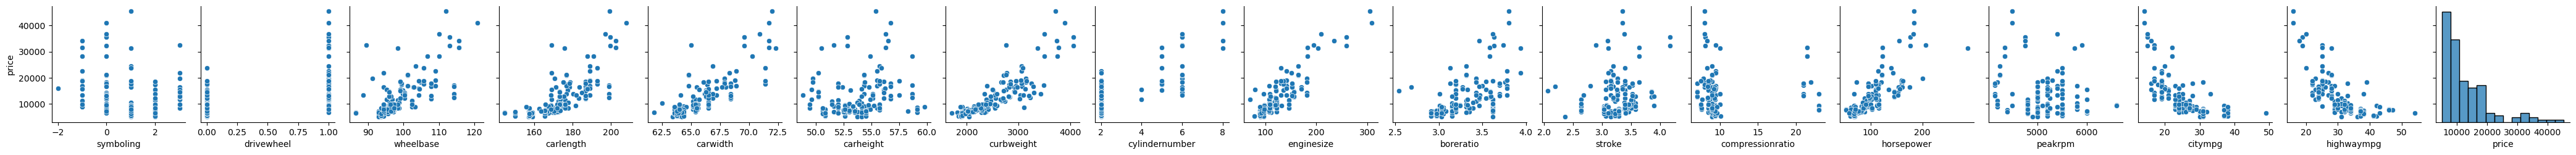

In [188]:
sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars=["price"])
plt.show()

In [189]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

<Axes: >

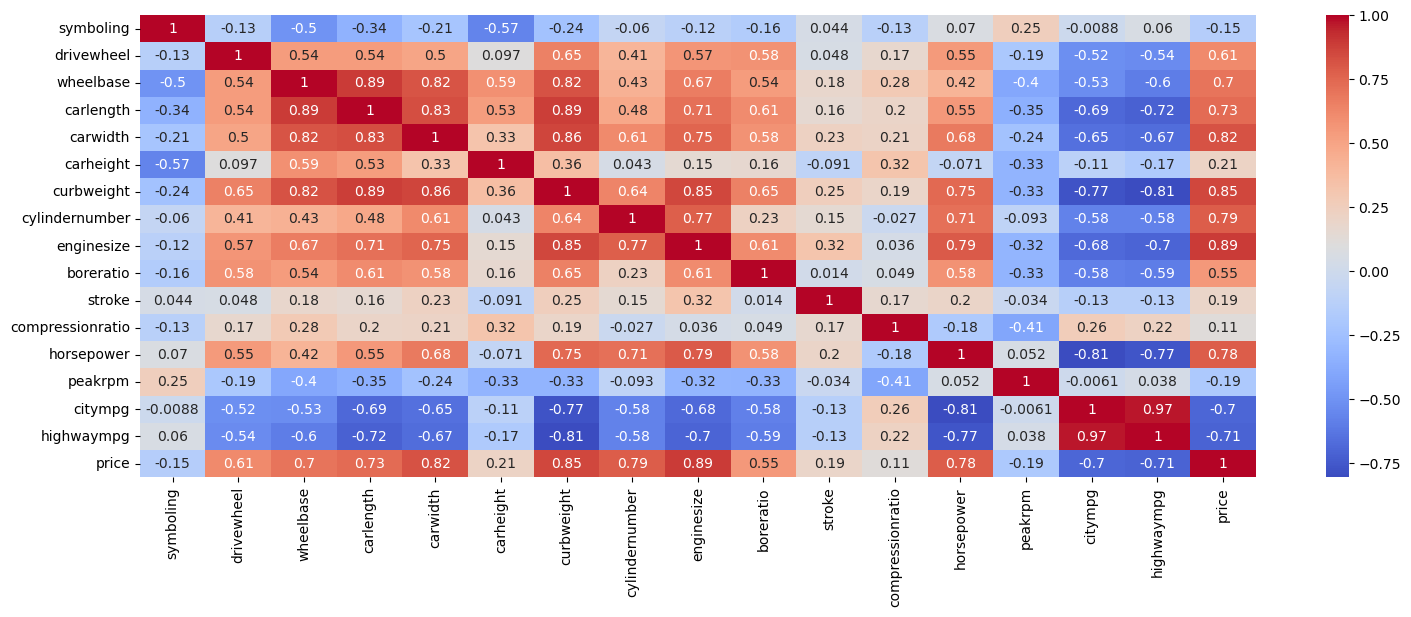

In [190]:
plt.figure(figsize=(18,6))
sns.heatmap(train_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap="coolwarm")

# Manual Feature Selection based on correlations

Dropping multicollinear features

In [191]:
train_data=train_data.drop(["carlength","wheelbase","compressionratio","citympg"])
test_data=test_data.drop(["carlength","wheelbase","compressionratio","citympg"])
to_remove = {"carlength", "wheelbase", "compressionratio", "citympg"}

num_cols = list(set(num_cols) - to_remove)

Dropping Based on variance inflation factor

In [192]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].drop("price","car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,4356.869147
3,curbweight,13.018512
6,enginesize,8.761981
12,horsepower,6.409083
9,cylindernumber,4.847119


In [193]:
train_data=train_data.drop("curbweight")
num_cols.remove("curbweight")
df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,3909.907747
5,enginesize,7.924996
11,horsepower,6.175088
8,cylindernumber,4.767296
9,boreratio,3.724297


In [194]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler


imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=8), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=8),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['highwaympg', 'carwidth',
                                                   'peakrpm', 'carheight',
                                                   'enginesize', 'stroke',
                                                   'symboling',
                                                   'cylindernumber',
                                                   'boreratio', 'drivewheel',
                                                   'horsepower'])])),
                ('lr', LinearRegression())])

Test Scores: [0.84570134 0.8046303  0.82398675 0.77194842 0.86163628]
Training Scores: [0.92061066 0.92321495 0.9236366  0.92127752 0.9134232 ]
Mean Test Score: 0.8215806179350601
Standard Deviation of Test Scores: 0.03144112973293444
Mean absolute Error: 2909.2064917922353
R-squared: 0.7407318763479438


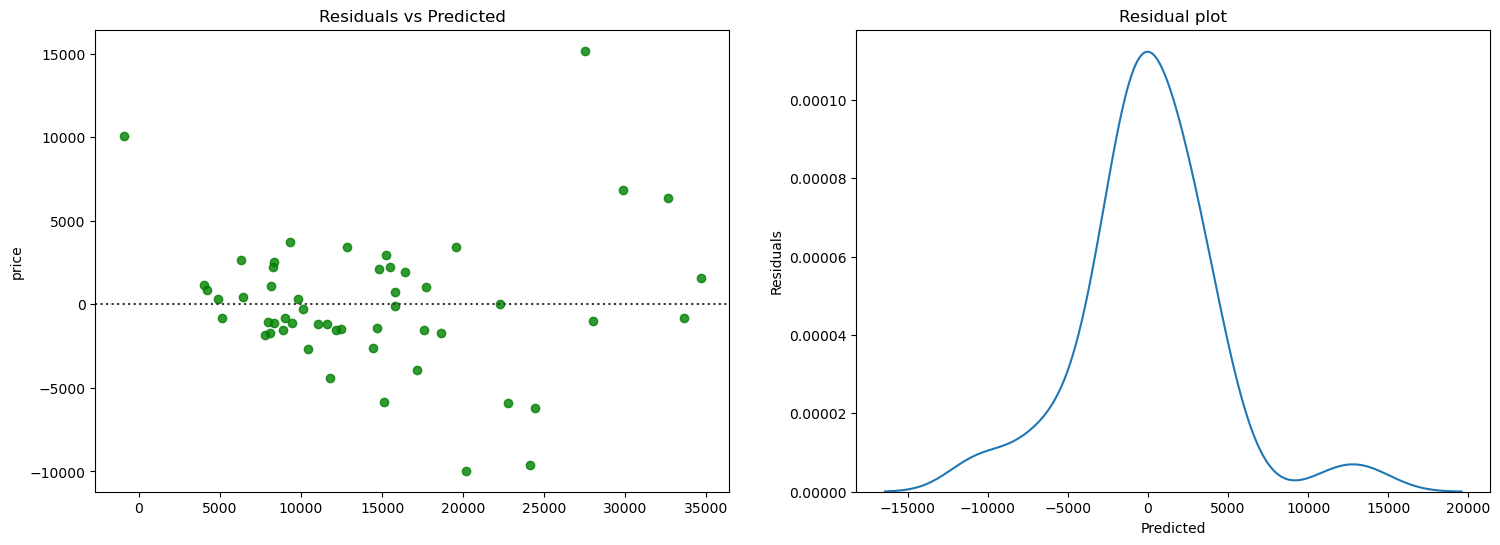

In [195]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error,r2_score

train_df = train_data.to_pandas()
test_df = test_data.to_pandas()
X_train, X_test, y_train, y_test = train_df.drop(["price","car_ID"],axis=1),test_df.drop(["price","car_ID"],axis=1),train_df['price'],test_df['price']

kf=KFold(n_splits=5)
cv_results = cross_validate(pipe, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

predictions = cross_val_predict(pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)

print(f'Mean absolute Error: {mae}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

## Performs little bit well in test sets compared to previous, Mean test score 82% with 3% deviation

### Not much change in residual range

### R2 score increased from 67 to 74 on holdout set and mean_absolute_error descreased from 3333 to 2909